In [2]:
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

In [4]:
geno_microglia = io_utils.loadGenotypes(
    '/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/microglia_pool_EURonly.vcf.gz',
    #'/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/monocyte_pool.vcf.gz.gz',
    maxlines = None, 
    posterior = False,
    print_every = 1e5,
    add_chr_prefix="").rename(columns = {"SNP" : "variantID"})
geno_microglia.head()

,position,contig,variantID,refAllele,altAllele,GSA8_0_RAJBrain_NPBB306,GSA8_0_RAJBrain_NPBB307,GSA8_0_RAJBrain_NPBB310,GSA8_0_RAJBrain_NPBB314,GSA8_0_RAJBrain_NPBB318,GSA8_0_RAJBrain_NPBB319,GSA8_0_RAJBrain_NPBB312,GSA8_0_RAJBrain_NPBB334,GSA8_0_RAJBrain_NPBB324
chr1:23308:G:C,23308,chr1,chr1:23308:G:C,G,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:409458:T:TTATTTA,409458,chr1,chr1:409458:T:TTATTTA,T,TTATTTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:595259:G:A,595259,chr1,chr1:595259:G:A,G,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:701203:G:T,701203,chr1,chr1:701203:G:T,G,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:708118:TCAC:T,708118,chr1,chr1:708118:TCAC:T,TCAC,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
geno_mono = io_utils.loadGenotypes(
    #'/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/microglia_pool_EURonly.vcf.gz',
    '/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/monocyte_pool.vcf.gz.gz',
    maxlines = None, 
    posterior = False,
    print_every = 1e5,
    add_chr_prefix="").rename(columns = {"SNP" : "variantID"})
geno_mono.head()

,position,contig,variantID,refAllele,altAllele,GSA6_54_NYUMD0149-01,GSA6_8_NYUMD0179-01,GSA6_112_BIMD0195-01,GSA3-PD3_176_NYUMD0079-01,GSA4_6_NYUMD0117-01,...,GSA8_0_NYUMD0280-01,GSA8_0_NYUMD0327-01,GSA3-PD3_209_NYUMD0041-01,GSA6_19_NYUMD0189-01,GSA6_80_NYUMD0163-01,GSA7_316_NYUMD0231,GSA4_78_NYUMD0087,GSA6_13_NYUMD0156-01,GSA5_16_NYUMD0075-01,GSA8_0_NYUMD0296-01
chr1:23308:G:C,23308,chr1,chr1:23308:G:C,G,C,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:409458:T:TTATTTA,409458,chr1,chr1:409458:T:TTATTTA,T,TTATTTA,0.5,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:595259:G:A,595259,chr1,chr1:595259:G:A,G,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:701203:G:T,701203,chr1,chr1:701203:G:T,G,T,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
chr1:708118:TCAC:T,708118,chr1,chr1:708118:TCAC:T,TCAC,T,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
microglia_counts_files = list(sorted(Path('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_European_only').glob('*')))
microglia_counts_files

[PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_European_only/CEBPB_eur_mic_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_European_only/CTCF_eur_mic_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_European_only/H3K27ac_eur_mic_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_European_only/MEF2C_eur_mic_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_European_only/PU1_eur_mic_allelic_out.txt')]

In [17]:
monocytes_counts_files = list(sorted(Path('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes').glob('*')))
monocytes_counts_files

[PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/CEBPB_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/CTCF_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/H3K27ac_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/MEF2C_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/PU1_mono_allelic_out.txt')]

In [27]:
tfs = [x.name.split("_")[0] for x in monocytes_counts_files]
tfs

['CEBPB', 'CTCF', 'H3K27ac', 'MEF2C', 'PU1']

In [29]:
def read_counts(counts_file):
     return pd.read_csv(counts_file,
                        sep = "\t",
                        usecols = range(8),
                        index_col = False)

In [30]:
geno_mono

,position,contig,variantID,refAllele,altAllele,GSA6_54_NYUMD0149-01,GSA6_8_NYUMD0179-01,GSA6_112_BIMD0195-01,GSA3-PD3_176_NYUMD0079-01,GSA4_6_NYUMD0117-01,...,GSA8_0_NYUMD0280-01,GSA8_0_NYUMD0327-01,GSA3-PD3_209_NYUMD0041-01,GSA6_19_NYUMD0189-01,GSA6_80_NYUMD0163-01,GSA7_316_NYUMD0231,GSA4_78_NYUMD0087,GSA6_13_NYUMD0156-01,GSA5_16_NYUMD0075-01,GSA8_0_NYUMD0296-01
chr1:23308:G:C,23308,chr1,chr1:23308:G:C,G,C,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:409458:T:TTATTTA,409458,chr1,chr1:409458:T:TTATTTA,T,TTATTTA,0.5,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:595259:G:A,595259,chr1,chr1:595259:G:A,G,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:701203:G:T,701203,chr1,chr1:701203:G:T,G,T,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
chr1:708118:TCAC:T,708118,chr1,chr1:708118:TCAC:T,TCAC,T,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22:50803709:T:A,50803709,chr22,chr22:50803709:T:A,T,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr22:50803843:C:G,50803843,chr22,chr22:50803843:C:G,C,G,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0
chr22:50804129:A:T,50804129,chr22,chr22:50804129:A:T,A,T,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr22:50805809:C:T,50805809,chr22,chr22:50805809:C:T,C,T,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
read_counts(monocytes_counts_files[0])

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,710225,chr1:710225:T:A,T,A,3,0,3
1,chr1,732994,chr1:732994:G:A,G,A,2,0,2
2,chr1,733014,chr1:733014:AG:A,AG,A,2,0,2
3,chr1,767578,chr1:767578:T:C,T,C,3,0,3
4,chr1,778597,chr1:778597:C:T,C,T,28,0,28
...,...,...,...,...,...,...,...,...
2557619,chr22,50770767,chr22:50770767:T:C,T,C,3,0,3
2557620,chr22,50780424,chr22:50780424:C:T,C,T,2,0,2
2557621,chr22,50780959,chr22:50780959:T:C,T,C,3,0,3
2557622,chr22,50790203,chr22:50790203:C:A,C,A,3,0,3


In [34]:
Path(".").absolute()

PosixPath('/home/dmeyer/projects/poolqtl/src')

sum(w)=0.956018 ideally would be 1


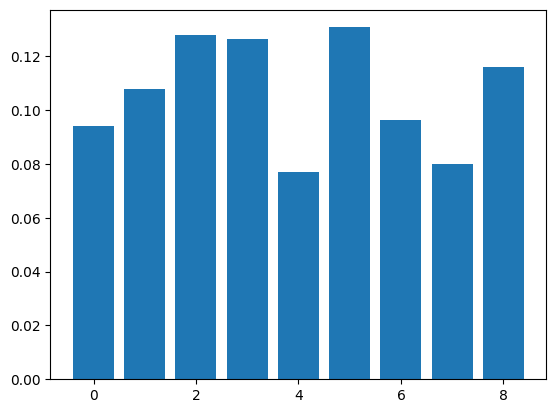

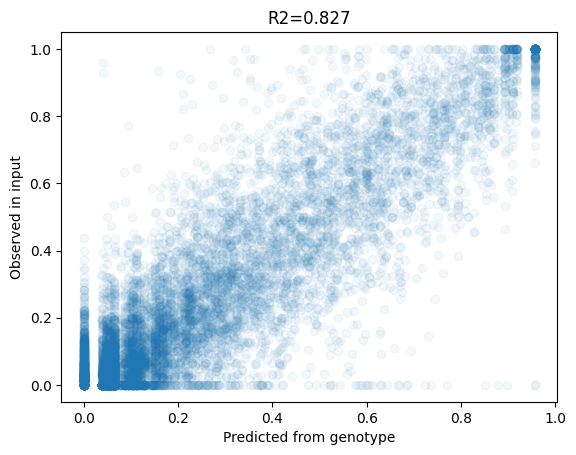

<Figure size 640x480 with 0 Axes>

In [41]:
w = deconvolve.deconvolve(
    geno_mono, 
    read_counts(monocytes_counts_files[0]), 
    sample_inds = range(5,14), 
    total_thres = 100, 
    plot = True
)
plt.savefig(f"/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/{tfs[0]}.jpg")

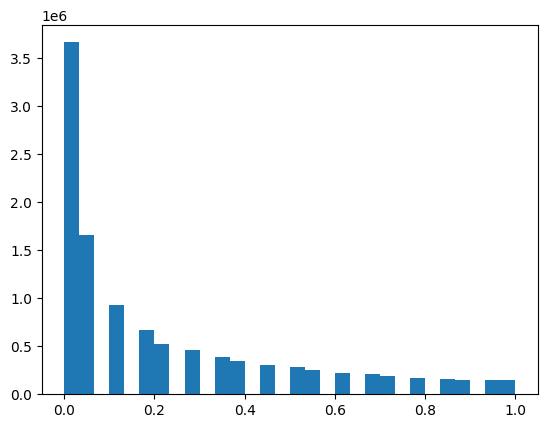

In [17]:
x = geno.iloc[:,5:].to_numpy()
maf = x.mean(1)
_ = plt.hist(maf,30)

In [18]:
geno_maf5 = geno.iloc[maf>=0.05,:]

sum(w)=0.910579 ideally would be 1


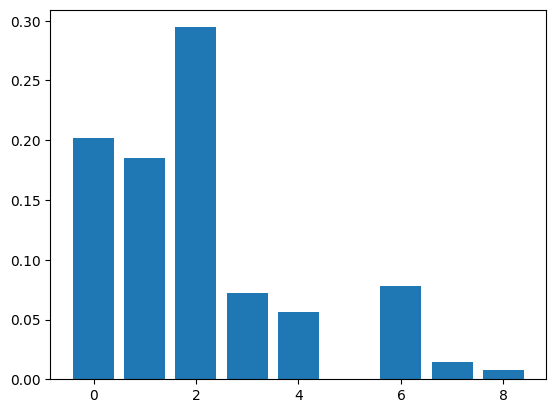

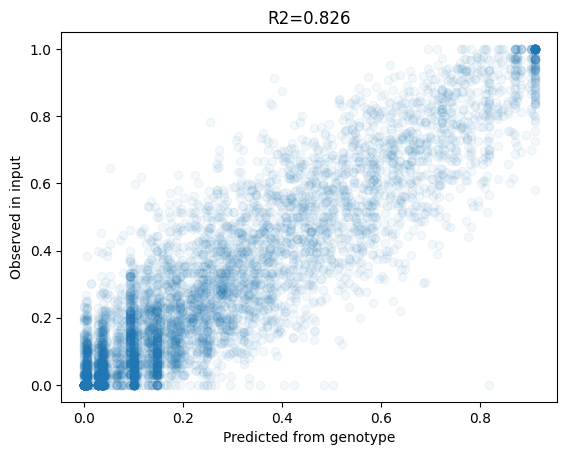

In [20]:
w = deconvolve.deconvolve(
    geno_maf5,
    counts, 
    sample_inds = range(5,14), 
    total_thres = 100, 
    plot = True
)

In [42]:
x = geno_maf5.iloc[:,5:].to_numpy()
maf = x.mean(1)

In [70]:
merged = geno_maf5.merge(counts, on = ["variantID", "refAllele", "altAllele", "contig", "position"]) # should we also join on contig? 


In [76]:
merged["maf"] = merged.iloc[:,5:15].to_numpy().mean(1)

Text(0, 0.5, 'AF in IP')

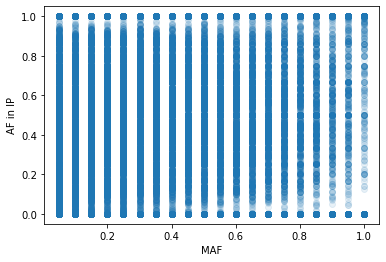

In [77]:
plt.scatter(merged.maf, merged.altCount / merged.totalCount, alpha = 0.1)
plt.xlabel("MAF")
plt.ylabel("AF in IP")

(array([9.14260e+04, 1.01183e+05, 0.00000e+00, 1.03654e+05, 9.60440e+04,
        1.45724e+05, 8.06540e+04, 4.03660e+04, 2.82870e+04, 1.43160e+04,
        1.25520e+04, 6.98900e+03, 6.10900e+03, 4.31100e+03, 3.69400e+03,
        2.70700e+03, 1.85800e+03, 1.44200e+03, 1.07200e+03, 7.50000e+02,
        5.45000e+02, 3.47000e+02, 2.47000e+02, 1.67000e+02, 8.80000e+01,
        5.30000e+01, 2.80000e+01, 6.00000e+00, 5.00000e+00, 3.00000e+00]),
 array([0.30103   , 0.39607194, 0.49111389, 0.58615583, 0.68119778,
        0.77623972, 0.87128167, 0.96632361, 1.06136556, 1.1564075 ,
        1.25144945, 1.34649139, 1.44153334, 1.53657528, 1.63161723,
        1.72665917, 1.82170111, 1.91674306, 2.011785  , 2.10682695,
        2.20186889, 2.29691084, 2.39195278, 2.48699473, 2.58203667,
        2.67707862, 2.77212056, 2.86716251, 2.96220445, 3.0572464 ,
        3.15228834]),
 <BarContainer object of 30 artists>)

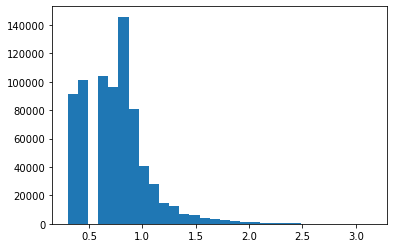

In [81]:
plt.hist(np.log10(merged.totalCount),30)

(array([80950.,   651.,   493.,   588.,   812.,  1267.,  1104.,  1280.,
         1692.,  1385.,  2250.,  1657.,  1246.,  1260.,   820.,   760.,
          769.,   329.,   573., 26056.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

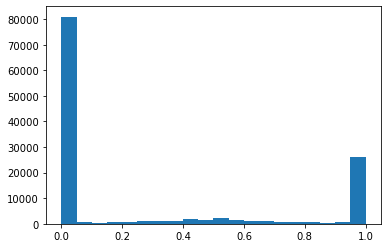

In [84]:
merged10 = merged[merged.totalCount >= 10]
plt.hist(merged10.altCount / merged10.totalCount, 20)

(125942, 19)

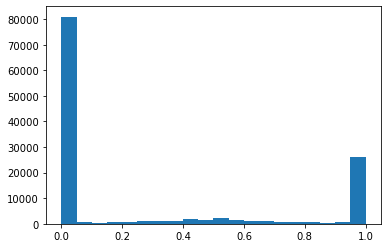

In [85]:
merged30 = merged[merged.totalCount >= 10]
plt.hist(merged30.altCount / merged30.totalCount, 20)
merged30.shape

In [66]:
(merged.totalCount > 100).sum()

3449